In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading raw itemsets data

In [3]:
itemset_results_path = pathlib.Path("../dataset/itemsets_weeks")
raw_itemsets_df = pd.read_csv(itemset_results_path, sep=' ', header=None, names=['dates', 'stations', 'density'])

In [4]:
raw_itemsets_df.columns

Index(['dates', 'stations', 'density'], dtype='object')

In [5]:
raw_itemsets_df.loc[0]

dates       23/10/2008:,02/02/2008:,04/10/2010:,18/02/2008...
stations    A915,A354,A402,A929,A916,A906,A927,A710,A933,A...
density                                              0.691863
Name: 0, dtype: object

# Creating dates and stations dfs

# Dates per itemset

In [6]:
item_1_dates = [date.split(":")[0] for date in raw_itemsets_df.loc[0].dates.split(",")]
len(item_1_dates)

340

In [7]:
dates_per_itemset_df = pd.DataFrame()
dates_per_itemset_df['date'] = item_1_dates
dates_per_itemset_df['date'] = pd.to_datetime(dates_per_itemset_df['date'], format="%d/%m/%Y")
dates_per_itemset_df['itemset'] = [1]*len(item_1_dates)

In [8]:
dates_per_itemset_df.head()

,date,itemset
0,2008-10-23,1
1,2008-02-02,1
2,2010-10-04,1
3,2008-02-18,1
4,2008-01-09,1


# Stations per itemset

In [9]:
item_1_stations = raw_itemsets_df.loc[0].stations.split(",")
len(item_1_stations)

287

In [10]:
stations_per_itemset_df = pd.DataFrame()
stations_per_itemset_df['station'] = item_1_stations
stations_per_itemset_df['itemset'] = [1]*len(item_1_stations)

# Plotting dates

In [13]:
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import numpy as np

In [24]:
dates_per_itemset_df['Ano'] = dates_per_itemset_df['date'].apply(lambda a: int(str(a.date()).split("-")[0]))
dates_per_itemset_df['dia_ano'] = dates_per_itemset_df['date'].apply(lambda a: a.date().timetuple().tm_yday)
dates_per_itemset_df['semana_do_ano'] = dates_per_itemset_df['dia_ano']//7

In [41]:
dates_per_itemset_df['semana_do_ano'].value_counts().sort_values(ascending=False)

semana_do_ano
1     14
49    14
47    13
7     13
51    13
43    13
45    13
3     13
41    12
11    12
9     11
5     11
13    11
48    11
6     10
50    10
10    10
0     10
8     10
46    10
39     9
44     9
42     9
2      9
38     7
15     7
4      7
12     7
37     6
40     6
14     4
18     4
16     4
21     3
52     3
17     3
20     2
35     2
19     2
29     1
24     1
36     1
Name: count, dtype: int64

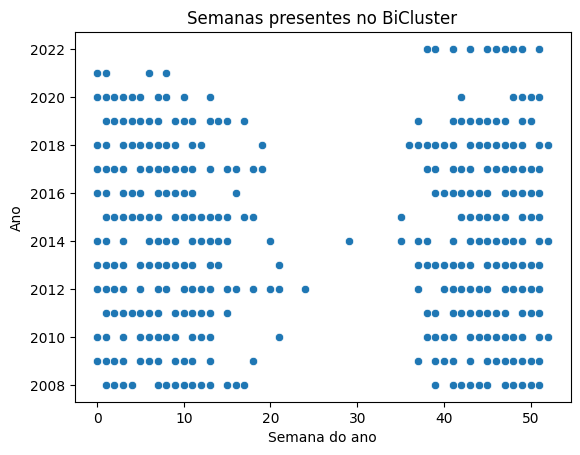

In [42]:
sns.scatterplot(dates_per_itemset_df, x='semana_do_ano',  y= 'Ano')
plt.title("Semanas presentes no BiCluster")
plt.xlabel("Semana do ano")
plt.ylabel("Ano")
plt.savefig("assets/semanas_no_grupo.png")
plt.show()

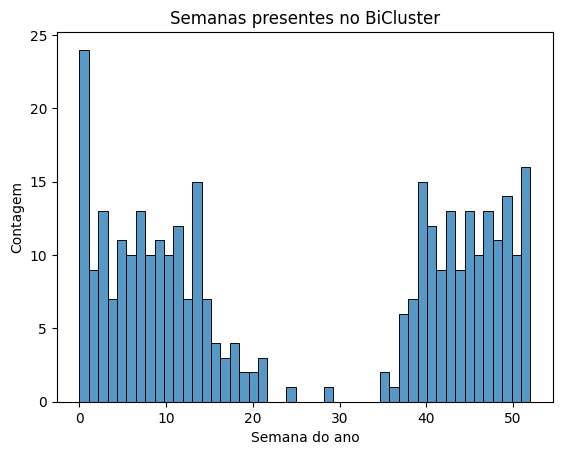

In [43]:
sns.histplot(dates_per_itemset_df, x='semana_do_ano', bins= 48)
plt.xlabel("Semana do ano")
plt.ylabel("Contagem")
plt.title("Semanas presentes no BiCluster")
plt.savefig("assets/semanas_no_grupo_hist.png")
plt.show()

# Ploting stations

In [44]:
stations_data_path = pathlib.Path("../dataset/STATION_DATA.CSV")
stations_info_df = pd.read_csv(stations_data_path, sep=";")

In [45]:
def get_longitude(x):
    a = stations_info_df.query('CODIGO == @x')['LONGITUDE'].values[0]
    return float(a.replace(',', '.'))

def get_latitude(x):
    a = stations_info_df.query('CODIGO == @x')['LATITUDE'].values[0]
    return float(a.replace(',', '.'))
    
stations_per_itemset_df['Longitude'] = stations_per_itemset_df['station'].apply(get_longitude)
stations_per_itemset_df['Latitude'] = stations_per_itemset_df['station'].apply(get_latitude)

In [46]:
stations_per_itemset_df.head()

,station,itemset,Longitude,Latitude
0,A915,1,-54.035278,-14.421389
1,A354,1,-42.146944,-6.974167
2,A402,1,-45.016667,-12.150000
3,A929,1,-54.956111,-13.686389
4,A916,1,-52.194444,-12.598611


In [47]:
stations_per_itemset_df.columns

Index(['station', 'itemset', 'Longitude', 'Latitude'], dtype='object')

In [48]:
BBox = (-72.78666666, -29.31666666, -33.74166666, 4.47749999)

In [49]:
stations_per_itemset_df.drop('itemset', axis=1, inplace=True)
stations_per_itemset_df['in itemset'] = 1

In [50]:
stations_info_df['LONGITUDE'] = stations_info_df['LONGITUDE'].apply(lambda x: float(x.replace(",", ".")))
stations_info_df['LATITUDE'] = stations_info_df['LATITUDE'].apply(lambda x: float(x.replace(",", ".")))

In [51]:
minor_stations_info_df = stations_info_df.drop(['REGIAO', 'UF', 'MUNICIPIO','ALTITUDE'], axis=1)

In [52]:
itemset_stations = stations_per_itemset_df['station'].values
minor_stations_info_df = minor_stations_info_df[~minor_stations_info_df.CODIGO.isin(itemset_stations)]

In [53]:
minor_stations_info_df['in itemset'] = 0
minor_stations_info_df = minor_stations_info_df[['CODIGO', 'LONGITUDE', 'LATITUDE', 'in itemset']]

In [54]:
minor_stations_info_df.head()

,CODIGO,LONGITUDE,LATITUDE,in itemset
2,A042,-48.131111,-15.599722,0
3,A046,-48.137500,-15.935278,0
4,A047,-47.557500,-16.011111,0
10,A056,-47.625833,-16.399444,0
11,A029,-49.914722,-17.336944,0


In [55]:
minor_stations_info_df.columns = ['station', 'Longitude', 'Latitude', 'in itemset']

In [56]:
chosen_and_not_df = pd.concat([minor_stations_info_df, stations_per_itemset_df], ignore_index=True)

In [57]:
chosen_and_not_df.head()

,station,Longitude,Latitude,in itemset
0,A042,-48.131111,-15.599722,0
1,A046,-48.137500,-15.935278,0
2,A047,-47.557500,-16.011111,0
3,A056,-47.625833,-16.399444,0
4,A029,-49.914722,-17.336944,0


In [58]:
climate_background_img = plt.imread('assets/mapa_trab2.png')

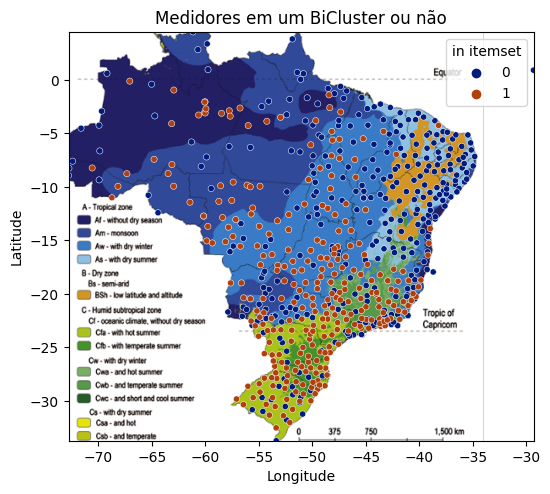

In [66]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=chosen_and_not_df, x='Longitude', y='Latitude', hue='in itemset', ax=ax, s=20, 
                palette='dark')
ax.set_title('Medidores em um BiCluster ou não')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.savefig("./assets/nclusterbox-itemset-and-not-climate.png")
plt.show()